In [ ]:
import pandas as pd
import eyefeatures.features.scanpath_complex as eye_complex
import eyefeatures.features.scanpath_complex as eye_complex
import eyefeatures.features.scanpath_dist as eye_dist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Getting distance matrices

In [49]:
data = pd.read_excel('data_for_scanpath_analysis.xlsx')

In [50]:
scanpaths = [x[1][['x', 'y']] for x in data.groupby(['participant', 'item'])]
y = [0 if x[1]['gr'].iloc[0]=='norm' else 1 for x in data.groupby(['participant', 'item'])]
sentence = [x[1]['item'].iloc[0] for x in data.groupby(['participant', 'item'])]

In [51]:
#hau_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_hau_dist)
#euc_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_euc_dist)
#man_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_man_dist)
#eye_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_eye_dist)
#dfr_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_dfr_dist)
#dtw_matrix = eye_complex.get_dist_matrix(scanpaths, dist_metric=eye_dist.calc_dtw_dist)

#eye_matrix.to_csv('eye_matrix.csv')
#dfr_matrix.to_csv('dfr_matrix.csv')
#dtw_matrix.to_csv('dtw_matrix.csv')
#hau_matrix.to_csv('hau_matrix.csv')
#euc_matrix.to_csv('euc_matrix.csv')
#man_matrix.to_csv('man_matrix.csv')

In [52]:
eye_matrix = pd.read_csv('eye_matrix.csv', index_col=0)
dfr_matrix = pd.read_csv('dfr_matrix.csv', index_col=0)
dtw_matrix = pd.read_csv('dtw_matrix.csv', index_col=0)
hau_matrix = pd.read_csv('hau_matrix.csv', index_col=0)
euc_matrix = pd.read_csv('euc_matrix.csv', index_col=0)
man_matrix = pd.read_csv('man_matrix.csv', index_col=0)

# Running umap to get embeddings from distances

Hausdorff |  groups:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\LEGION\anaconda3\envs\eyefeatures_env\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\LEGION\anaconda3\envs\eyefeatures_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Hausdorff |  groups:   3%|▎         | 1/30 [00:00<00:03,  8.18it/s]c:\Users\LEGION\anaconda3\envs\eyefeatures_env\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\LEGION\anaconda3\envs\eyefeatures_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Hausdorff |  groups:

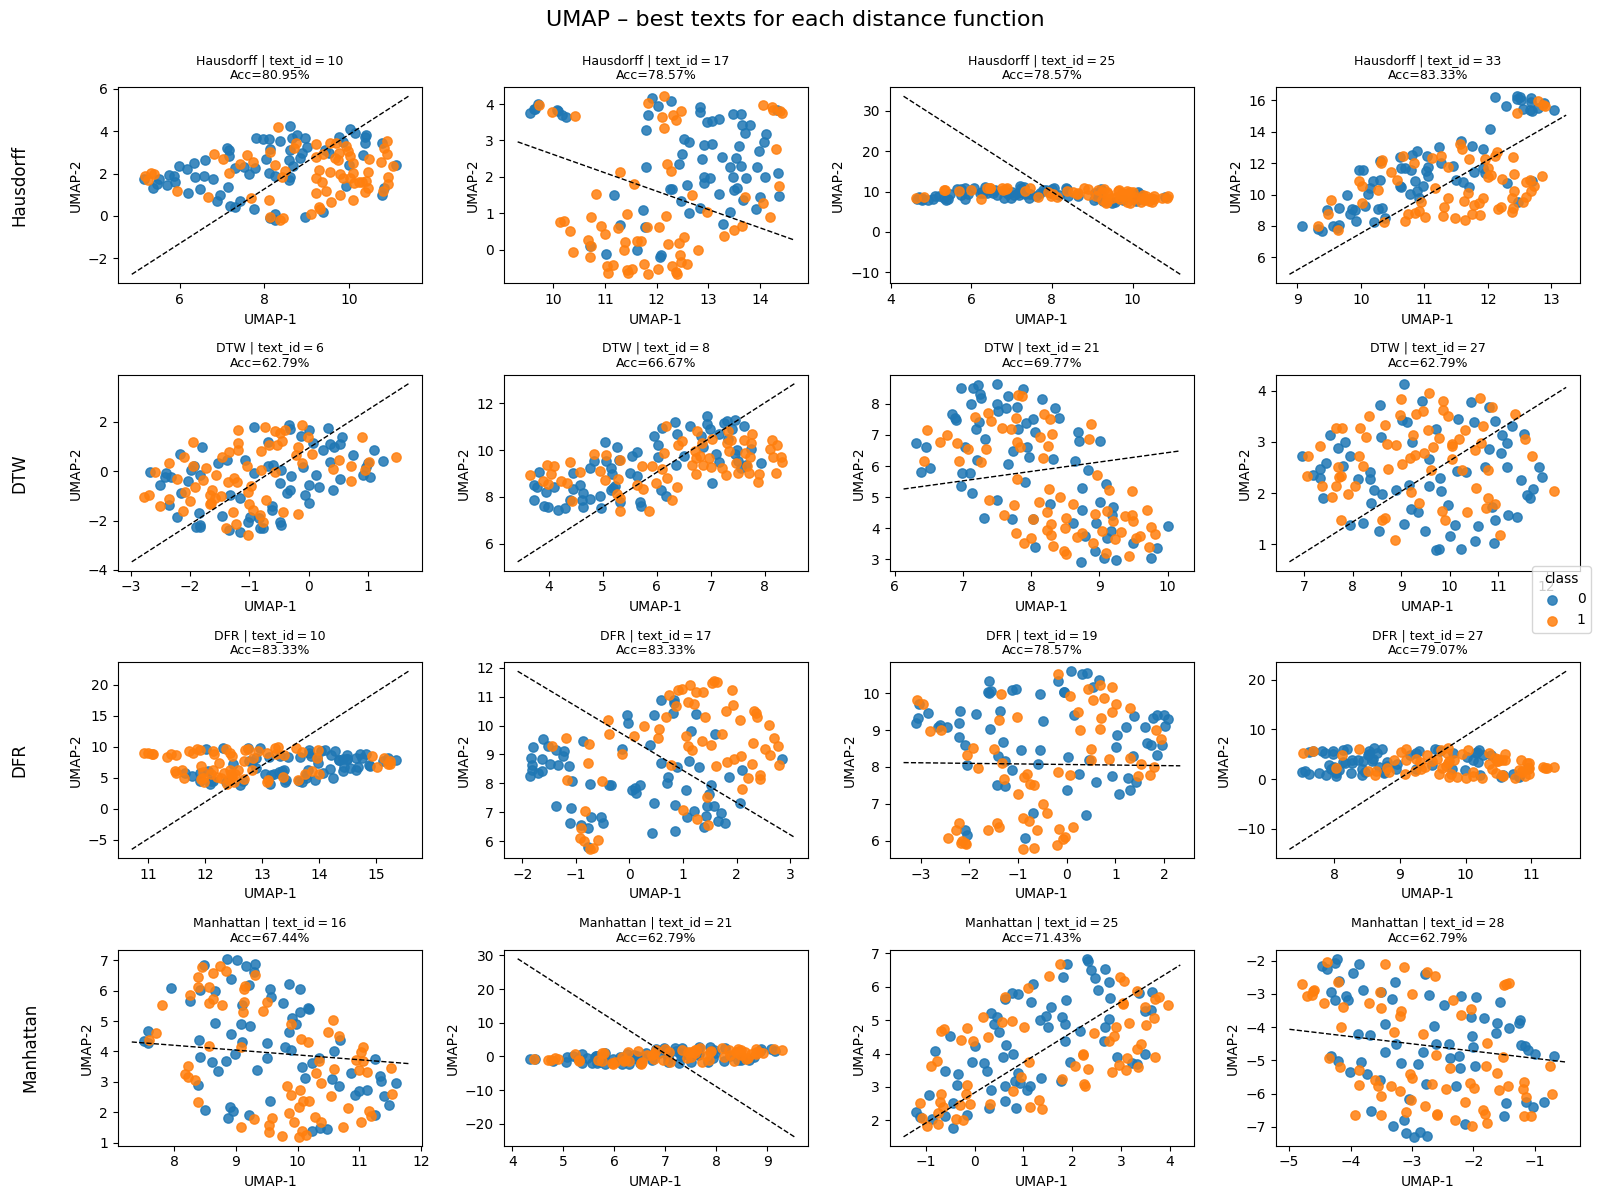

In [ ]:
import re
from itertools import cycle
from tqdm import tqdm
import numpy as np
from umap import UMAP
from sklearn.svm import SVC

# --------------------------------------------------------------------------
# helper to sort IDs naturally:  "10" comes after "2",  "text_12" after "text_3"
# --------------------------------------------------------------------------
def _natkey(s):
    return [int(tok) if tok.isdigit() else tok.lower()
            for tok in re.split(r'(\d+)', str(s))]

# --------------------------------------------------------------------------
# Low‑level helper – plots ONE distance matrix (one row in the final grid)
# --------------------------------------------------------------------------
def _plot_one_umap_best_groups(
        D, labels, groups, *, ax,
        n_components=2, random_state=228,
        test_size=.30, top_n=4,
        cmap_cycle=("tab10", "Set2", "Dark2"),
        global_handles=None,
        title_prefix="",
        umap_params=None):

    # -- validation ------------------------------------------------------
    D, labels, groups = map(np.asarray, (D, labels, groups))
    n = D.shape[0]
    if D.shape != (n, n):
        raise ValueError("D must be square")
    if labels.shape[0] != n or groups.shape[0] != n:
        raise ValueError("labels / groups length mismatch")
    if global_handles is None:
        global_handles = {}

    uniq_groups = np.unique(groups)

    # -- per‑group UMAP + SVM -------------------------------------------
    embeddings = np.full((n, n_components), np.nan)
    svm_scores, svms = {}, {}
    for g in tqdm(uniq_groups, desc=f"{title_prefix} groups"):
        idx = np.where(groups == g)[0]
        if len(idx) < 4 or len(np.unique(labels[idx])) < 2:
            continue

        reducer = UMAP(n_components=n_components,
                       metric="precomputed",
                       random_state=random_state,
                       **(umap_params or {}))
        embeddings[idx] = reducer.fit_transform(D[np.ix_(idx, idx)])
        X_emb = embeddings[idx]

        # you can keep / drop the split – here we still split:
        Xtr, Xte, ytr, yte = train_test_split(
            X_emb, labels[idx], test_size=test_size,
            stratify=labels[idx], random_state=random_state)
        svm = SVC(kernel="linear", C=1, random_state=random_state)
        svm.fit(Xtr, ytr)
        acc = svm.score(Xte, yte)

        svm_scores[g] = acc
        svms[g] = svm

    if not svm_scores:
        raise ValueError("No scorable groups")

    # ---------- choose & **order** groups --------------------------------
    best = sorted(svm_scores, key=svm_scores.get, reverse=True)[:top_n]  # pick by score
    chosen = sorted(best, key=_natkey)                                   # order by text_id

    # ---------- plot -----------------------------------------------------
    cmaps = cycle(cmap_cycle)
    for axis, g, cmap in zip(ax, chosen, cmaps):
        mask = groups == g
        Xg, yg = embeddings[mask], labels[mask]

        # points
        for cls in np.unique(yg):
            pts = yg == cls
            sc = axis.scatter(Xg[pts, 0], Xg[pts, 1],
                              s=45, alpha=.85, cmap=cmap,
                              label=str(cls))
            if cls not in global_handles:
                global_handles[cls] = sc

        # linear boundary
        w, b = svms[g].coef_[0], svms[g].intercept_[0]
        if abs(w[1]) > 1e-10:
            xlim = np.array(axis.get_xlim())
            ylim = -(w[0] * xlim + b) / w[1]
            axis.plot(xlim, ylim, '--', lw=1, c='black', label='_nolegend_')
        else:
            axis.axvline(x=-b / w[0], ls='--', lw=1, c='black', label='_nolegend_')

        axis.set_title(f"{title_prefix}text_id = {g}\nAcc={svm_scores[g]:.2%}",
                       fontsize=9)
        axis.set_xlabel("UMAP‑1"); axis.set_ylabel("UMAP‑2")

    # hide unused axes (if < top_n groups were plottable)
    for axis in ax[len(chosen):]:
        axis.set_visible(False)

    return {"chosen_groups": chosen,
            "test_accuracy": {g: svm_scores[g] for g in chosen}}



def plot_umap_best_groups_grid(
        matrices,
        names,
        labels: np.ndarray,
        groups: np.ndarray,
        *,
        top_n: int = 4,
        n_components: int = 2,
        random_state: int = 228,
        test_size: float = .30,
        size_per_plot: Tuple[int, int] = (4, 3),
        cmap_cycle: Tuple[str, ...] = ("tab10", "Set2", "Dark2"),
        figure_title: str = "UMAP – best texts for each distance function",
        umap_params: Dict | None = None
):
    """
    Create a single figure with one *row per distance matrix* and
    `top_n` columns – the best‑performing groups.

    Parameters
    ----------
    matrices, names
        Sequences of equal length. `names` appear as row titles.
    labels, groups
        1‑D arrays of length n.
    umap_params
        Extra keyword arguments forwarded to `UMAP(...)` (e.g. `n_neighbors`).
    """

    n_rows, n_cols = len(matrices), top_n
    w, h = size_per_plot
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(w * n_cols, h * n_rows),
        squeeze=False
    )

    global_handles = {}
    summaries = {}

    for r, (D, title) in enumerate(zip(matrices, names)):
        row_axes = axes[r]
        summaries[title] = _plot_one_umap_best_groups(
            D, labels, groups,
            ax=row_axes,
            n_components=n_components,
            random_state=random_state,
            test_size=test_size,
            top_n=top_n,
            cmap_cycle=cmap_cycle,
            global_handles=global_handles,
            title_prefix=f"{title} | ",
            umap_params=umap_params
        )

        # annotate row name once along left margin
        row_axes[0].annotate(title, xy=(0, .5),
                             xytext=(-row_axes[0].yaxis.labelpad - 25, 0),
                             xycoords=row_axes[0].yaxis.label,
                             textcoords='offset points',
                             size='large', ha='right', va='center',
                             rotation=90)

    # global legend (right‑hand side)
    fig.legend(global_handles.values(), global_handles.keys(),
               loc="center right", title="class")
    fig.subplots_adjust(right=.85)
    fig.suptitle(figure_title, fontsize=16, y=.995)
    plt.tight_layout()
    plt.show()

    return summaries


# ──────────────────────────────────────────────────────────────────────────────
# Example usage
# ──────────────────────────────────────────────────────────────────────────────

if True:
    summaries = plot_umap_best_groups_grid(
        matrices=[
            hau_matrix, 
            dtw_matrix, 
            dfr_matrix, 
            man_matrix, 
            ],
        names=[
            "Hausdorff", 
            "DTW", 
            "DFR", 
            "Manhattan", 
            ],
        labels=y,
        groups=sentence,
        top_n=4,
    )
